# **Dataset Selection**

Three datasets were selected before arriving at the final dataset below. <br>


A dataset of images of rice grains from different species was obtained from Kaggle, at the following address: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset <br> <br> The following code was used to import the dataset from Kaggle, using the kagglehub package suggested by Kaggle, as well as some modules and packages for image processing.

The pre-trained VGG16 CNN model was also imported for image clustering.

In [1]:
!pip install kagglehub # Install the kagglehub package if you don't have it.
import kagglehub
import os
import pandas as pd
!pip install opencv-python
import cv2 #for reading of images

#We require some functions, that are found within the keras module of the tensorflow package
!pip install tensorflow
import tensorflow as tf # Keras is now part of TensorFlow
from tensorflow import keras
from keras import preprocessing
from keras import applications

from keras.preprocessing.image import load_img, img_to_array # These are in keras.preprocessing.image
# load_img allows image to be loaded as a PIL object
# img_to_array converts images (in PIL object) into a NumPy array

from keras.applications.vgg16 import preprocess_input, VGG16 # These are in keras.applications.vgg16
# preproccess_input prepares image in a format the model requires.
# VGG16 is a pre-trained CNN model we're using to recognise our images.

!pip install scikit-learn
from sklearn.cluster import KMeans # KMeans is in sklearn.cluster. It is the clustering algorithm we’re going to use
from sklearn.decomposition import PCA # PCA is in sklearn.decomposition. To be used for dimensionality reduction later on, if there are too many variables

from PIL import Image  # Import Image class from PIL, which helps us call up images
import matplotlib.pyplot as plt # Import matplotlib for displaying images

# Download latest version of the data
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")

file_path = os.path.join(dataset_path, "Rice_Image_Dataset")

# -----------------------------------------------------------------------------
# 1. Set the dataset directory and allowed image extensions
# -----------------------------------------------------------------------------
dataset_dir = dataset_path
allowed_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']



# **Dataset Preprocessing**

The images, file paths and categories were first organised into a dictionary for ease of working later on.
<br> <br> Additionally, the number of files was counted and a visual inspection of each rice grain was conudcted, to ensure that they were distinguishable to humans visually.

Found 75000 image files.
Images per category:
Arborio: 15000 images
Basmati: 15000 images
Ipsala: 15000 images
Jasmine: 15000 images
Karacadag: 15000 images


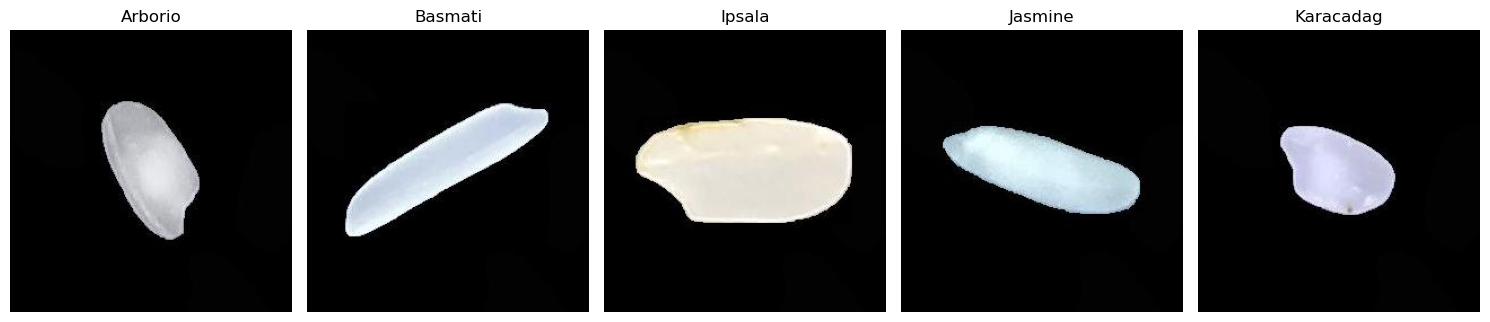

In [2]:
# -----------------------------------------------------------------------------
# 2. Collect all image file paths in a list
# -----------------------------------------------------------------------------
image_files = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in allowed_exts:
            image_files.append(os.path.join(root, file))
print(f"Found {len(image_files)} image files.")

# -----------------------------------------------------------------------------
# 3. Define the five categories and create a dictionary for grouping
# -----------------------------------------------------------------------------
categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
category_dict = {cat: [] for cat in categories}

# -----------------------------------------------------------------------------
# 4. Group images into the appropriate category based on file name
# -----------------------------------------------------------------------------
for filepath in image_files:
    basename = os.path.basename(filepath).lower()
    for cat in categories:
        if cat.lower() in basename:
            category_dict[cat].append(filepath)
            break  # Assign image to the first matching category

# -----------------------------------------------------------------------------
# 5. Print counts for each category (basically a high-level summary of category_dict)
# -----------------------------------------------------------------------------
print("Images per category:")
for cat, files in category_dict.items():
    print(f"{cat}: {len(files)} images")

# -----------------------------------------------------------------------------
# 6. Display the first image of each category as a visual check
# -----------------------------------------------------------------------------
plt.figure(figsize=(15, 5))
for i, cat in enumerate(categories):
    if category_dict[cat]:
        first_img_path = category_dict[cat][0]
        try:
            with Image.open(first_img_path) as img:
                plt.subplot(1, len(categories), i+1)
                plt.imshow(img)
                plt.title(cat)
                plt.axis('off')
        except Exception as e:
            print(f"Error loading image for category {cat}: {e}")
plt.tight_layout()
plt.show()

In [3]:
import numpy as np

# Load the image
# Accessing an image path from your new category_dict structure
first_category = list(category_dict.keys())[0]  # Example: Arborio
first_image_path = category_dict[first_category][0]
test_image = load_img(first_image_path, target_size=(224, 224))

# Convert the image to a NumPy array
test_image_array = img_to_array(test_image)

# Reshape the array to add the batch dimension
test_image_array = np.expand_dims(test_image_array, axis=0)

# Preprocess the image for the VGG16 model
preprocess_test_image_array = preprocess_input(test_image_array)

# Test if the logic for creating an array for one image works
print(preprocess_test_image_array.shape)

(1, 224, 224, 3)


In [4]:
# We now use the same process to convert all the images to arrays
# This takes about 9 minutes on Colab and Jupyter.

# Here, we install and load the tqdm library, so we can have a progress bar
# to visualise how far along the image conversion is.
!pip install tqdm
from tqdm import tqdm


import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Create a directory to store preprocessed images
preprocessed_dir = 'preprocessed_images'
os.makedirs(preprocessed_dir, exist_ok=True)

# We know that there are 75000 images from previously
total_images = 75000

# Use tqdm to create a progress bar
with tqdm(total=total_images, desc="Preprocessing Images") as pbar:
    # Iterate through all images in category_dict
    for category, filepaths in category_dict.items():
        for filepath in filepaths:
            try:
                # Preprocess the image using the image path
                image = load_img(filepath, target_size=(224, 224))  # Load image
                image_array = img_to_array(image)
                image_array = np.expand_dims(image_array, axis=0)
                preprocessed_image = preprocess_input(image_array)

                # Save the preprocessed image to disk
                image_filename = os.path.splitext(os.path.basename(filepath))[0] + '_preprocessed.npy'
                image_filepath = os.path.join(preprocessed_dir, image_filename)
                np.save(image_filepath, preprocessed_image)

                 # Update the progress bar
                pbar.update(1)

            except Exception as e:
                print(f"Error processing {filepath}: {e}")


Preprocessing Images: 100%|██████████| 75000/75000 [10:42<00:00, 116.66it/s]


# **Model Training and Evaluation**

In [ ]:
# Takes 1 hour to run

# Install TensorFlow for Apple Silicon, so we can use GPU acceleration
!pip install tensorflow-macos
!pip install tensorflow-metal

def extract_features_and_reduce_dim(category_dict, num_components=50, preprocessed_dir='preprocessed_images'):
    """
    Extracts features from preprocessed images using VGG16, removes the output layer,
    and performs dimensionality reduction using PCA.

    Args:
        category_dict (dict): Dictionary where keys are categories and
                               values are lists of image file paths.
        num_components (int): Number of principal components to keep (default: 50).
        preprocessed_dir (str): Directory containing preprocessed images.

    Returns:
        tuple: A tuple containing the features dictionary and the fitted PCA object.
    """

    # Check for GPU availability
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

    # Load the VGG16 model without the classification layers
    base_model = VGG16(weights='imagenet', include_top=False, pooling='avg')

    features_dict = {}

    # Calculate total number of images
    total_images = sum(len(filepaths) for filepaths in category_dict.values())

    # Use tqdm to create a progress bar
    with tqdm(total=total_images, desc="Extracting Features") as pbar:
        counter = 0
        # Iterate through images in category_dict
        for category, filepaths in category_dict.items():
            for image_path in filepaths:
                try:
                    # Load preprocessed image
                    image_filename = os.path.splitext(os.path.basename(image_path))[0] + '_preprocessed.npy'
                    preprocessed_image_path = os.path.join(preprocessed_dir, image_filename)
                    img_data = np.load(preprocessed_image_path)

                    # Preprocess the image for VGG16
                    img_data = preprocess_input(img_data)

                    # Extract features
                    features = base_model.predict(img_data)
                    features = features.flatten()  # Flatten the features to a 1D array

                    # Store features in the dictionary using filename as key
                    filename = os.path.basename(image_path)
                    features_dict[filename] = features

                    # Update the progress bar here after 50 images
                    counter += 1
                    if counter % 50 == 0:
                        pbar.update(50)

                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Perform dimensionality reduction using PCA
    all_features = np.array(list(features_dict.values()))
    pca = PCA(n_components=num_components)
    reduced_features = pca.fit_transform(all_features)

    # Update features_dict with reduced features
    for i, filename in enumerate(features_dict.keys()):
        features_dict[filename] = reduced_features[i]

    return features_dict, pca

# Call the function to extract the features and perform PCA on our images
features_dict, pca = extract_features_and_reduce_dim(category_dict)  # Pass category_dict directly


In [ ]:
# The code above takes a long time to run, so we save the output as a file for ease of continuing

import pickle
with open('data.pk1', 'wb') as f:
    pickle.dump({'dictionary':features_dict, 'pca':pca}, f)

In [9]:
# We can load the output back in with this code.

import pickle

'''
from google.colab import drive

drive.mount('/content/drive')
'''

# Now you can access the file from Drive, for example:
with open('data.pk1', 'rb') as f:
          data = pickle.load(f)

# Extract the saved objects
features_dict = data['dictionary']
pca = data['pca']

# Now you can use features_dict and pca as needed


In [9]:
import numpy as np
from sklearn.cluster import KMeans # KMeans is in sklearn.cluster. It is the clustering algorithm we’re going to use

# Now that we have a smaller feature set, we are ready to cluster our images.

# We know that there are 5 clusters, ideally (5 different types of rice).
# So we initialise k=5 to see how it does

# Prepare data for KMeans
# Get feature vectors from features_dict
feature_vectors = np.array(list(features_dict.values()))

# Create and Fit KMeans Model
# Assuming you want 5 clusters (for 5 types of rice)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=5)  # Initialize KMeans, with a seed for reproduceability?
kmeans.fit(feature_vectors)  # Fit KMeans to the feature vectors

# Get the generated cluster labels for each image
labels = kmeans.labels_

# Create a dictionary mapping filenames to cluster labels
filename_to_cluster = dict(zip(features_dict.keys(), labels))

# We can visualise the created clusters
for cluster_id in range(num_clusters):
       print(f"Cluster {cluster_id}:")
       for filename, label in filename_to_cluster.items():
           if label == cluster_id:
               print(f"  - {filename}")

Streaming output truncated to the last 5000 lines.
  - Jasmine (4976).jpg
  - Jasmine (13238).jpg
  - Jasmine (8056).jpg
  - Jasmine (14007).jpg
  - Jasmine (9094).jpg
  - Jasmine (7989).jpg
  - Jasmine (12350).jpg
  - Jasmine (10697).jpg
  - Jasmine (8685).jpg
  - Jasmine (2288).jpg
  - Jasmine (7570).jpg
  - Jasmine (2772).jpg
  - Jasmine (984).jpg
  - Jasmine (13054).jpg
  - Jasmine (9978).jpg
  - Jasmine (10678).jpg
  - Jasmine (4219).jpg
  - Jasmine (3476).jpg
  - Jasmine (11).jpg
  - Jasmine (9581).jpg
  - Jasmine (10228).jpg
  - Jasmine (7966).jpg
  - Jasmine (4167).jpg
  - Jasmine (1365).jpg
  - Jasmine (9305).jpg
  - Jasmine (1735).jpg
  - Jasmine (4864).jpg
  - Jasmine (6859).jpg
  - Jasmine (8144).jpg
  - Jasmine (14115).jpg
  - Jasmine (2119).jpg
  - Jasmine (8001).jpg
  - Jasmine (14050).jpg
  - Jasmine (13795).jpg
  - Jasmine (4921).jpg
  - Jasmine (5799).jpg
  - Jasmine (5263).jpg
  - Jasmine (10910).jpg
  - Jasmine (10443).jpg
  - Jasmine (4472).jpg
  - Jasmine (316).jp

In [10]:
# We can see that the clustering is not perfect, with each cluster having multiple rice grain types

# We evaluate the performance of the clustering with the use of Silhouette score
# This is the equivalent of calculating accuracy in an unsupervised, clustering model

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(feature_vectors, labels)

print(f"Silhouette Score: {silhouette_avg}")

# we can also calculate homogeneity, and completeness
# Homogeneity is a measure of how well the clusters contain only data points from a single class, while
# completeness is a measure of how well all data points of a single class are assigned to the same cluster

from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Before we can calculate these measures, we need to create a mapping of rice type to each file
# Let us add this mapping to the existing features_dict dictionary
# Step 1: Get rice type from filename
def get_rice_type(filename):
    return filename.split(' ')[0]  # Splits on space and takes first part

# Step 2: Create a mapping of rice types to numerical labels
rice_types = set(get_rice_type(filename) for filename in features_dict.keys())
rice_type_to_label = {rice_type: i for i, rice_type in enumerate(rice_types)}

# Step 3: Assign true_labels
true_labels = [rice_type_to_label[get_rice_type(filename)] for filename in features_dict.keys()]

homogeneity = homogeneity_score(true_labels, labels)
completeness = completeness_score(true_labels, labels)
v_measure = v_measure_score(true_labels, labels)

print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")

Silhouette Score: 0.1712494194507599
Homogeneity: 0.5285325025364103
Completeness: 0.532383044909088
V-measure: 0.5304507860428158


In [ ]:
# As we can see, the silhouette score is low, indicating poor clustering.
# Per Benaya et. al in 2023, a score of 0.5 and above indicates good clustering.

# Likewise, homogeneity, completeness, and V-measure return less than ideal scores, with
# scores of 1 expected for perfect clustering in all three measures.
# Homogeneity calculates how much a cluster contains only one class
# Completeness measures how much all members of a given class are assigned to the same cluster
# V-measure is the harmonic mean of homogeneity and completeness

# An earlier attempt of clustering, with 150 images each, yielded the following scores:
"Silhouette Score: 0.1499919593334198"
"Homogeneity: 0.4822916345385136"
"Completeness: 0.48767242523893267"
"V-measure: 0.4849671051560643"

# The gain in performance from a much larger dataset (100x larger) is not very signficant.
# Silhouette score improved by ~0.02 and V-measure improved by ~0.05.

# Reference:
# Benaya, Raisa & Sibaroni, Yuliant & Ihsan, Aditya. (2023). Clustering Content Types and User Roles Based on Tweet Text Using K-Medoids Partitioning Based. Journal of Computer System and Informatics (JoSYC). 4. 749-756. 10.47065/josyc.v4i4.3751.

In [ ]:
# One possible hypothesis is that we have over-simplified the features of the images with PCA
# This is because the VGG16 model has shown transferability to many other image recognition tasks.

# Hence, we aim to calculate how much variance our current 50 PCA dimensions accounts for.

total_variance_explained = pca.explained_variance_ratio_.sum()

print(f"Total variance explained by 50 PCA dimensions: {total_variance_explained:.4f}")


Total variance explained by 50 PCA dimensions: 0.9251


In [ ]:
# We actually get a pretty good result - the 50 chosen dimensions accounts for 92.2% of total variance.
# This implies that the poor performance of the clustering model is not due to an over-simplification
# of the data set.


# Other hypotheses include
# 1) Not enough images for model to learn from. Potential solution: k-fold cross validation.
# 2) Placement of initial centroids are causing errors. Potential solution: vary the initial clusters and see the result.
# 3) (not applicable in this case) Wrong k chosen. For exploration, we can use different k, and see how the silhouette score varies.
# In theory, any k that is not k = 5 should give worse silhouette scores, since we already know there are 5 different types of rice.
# 4) the feature extraction method was not suitable. Potential solution: switch to edge detection, since each rice grain has a distinct shape.


# We shall test 5-fold cross validation here, and the other hypotheses in their respective section.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Get feature vectors from features_dict
feature_vectors_cv = np.array(list(features_dict.values()))

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds, shuffled data

# Lists to store silhouette scores for each fold
silhouette_scores_cv = []

# Iterate through folds
for fold, (train_index, test_index) in enumerate(kf.split(feature_vectors_cv)):
    print(f"Fold {fold + 1}")

    X_train, X_test = feature_vectors_cv[train_index], feature_vectors_cv[test_index]

    # Initialize and train KMeans on the training data
    kmeans_cv = KMeans(n_clusters=5, random_state=42)  # Assuming 5 clusters
    kmeans_cv.fit(X_train)

    # Predict cluster labels for the test data
    cluster_labels = kmeans_cv.predict(X_test)

    # Calculate silhouette score for the current fold and append to the list
    silhouette_avg = silhouette_score(X_test, cluster_labels)
    silhouette_scores_cv.append(silhouette_avg)
    print(f"Silhouette Score: {silhouette_avg}")
    print("-" * 30)

# Calculate average silhouette score across folds
avg_silhouette_score = np.mean(silhouette_scores_cv)
print(f"Average Silhouette Score: {avg_silhouette_score}")


Fold 1
Silhouette Score: 0.17109465599060059
------------------------------
Fold 2
Silhouette Score: 0.17120786011219025
------------------------------
Fold 3
Silhouette Score: 0.17151068150997162
------------------------------
Fold 4
Silhouette Score: 0.17083676159381866
------------------------------
Fold 5
Silhouette Score: 0.1713443249464035
------------------------------
Average Silhouette Score: 0.17119885981082916


In [ ]:
# We can see that 5-fold cross validation has little impact on the silhouette score
# (both are 0.1712 before and after 5-fold cv).

# This suggests that the other hypotheses mentioned earleir may be correct.

# Additionally, it may suggest that KMeans clustering is not suitable for this task, as
# the features may not be normalized for distance-based clustering methods like K-Means,
# or the data distribution is not suitable for spherical clusters.

In [ ]:
# We now attempt to see if position of initial clusters can affect the clustering accuracy.
# KMeans, by default, spreads out the initial centroids, to avoid poor local optima.
# Hence, one would expect the above Silhouette scores to be optimised already.

# Let us see the impact of using random clusters below.

import numpy as np
from sklearn.cluster import KMeans # KMeans is in sklearn.cluster. It is the clustering algorithm we’re going to use

# Now that we have a smaller feature set, we are ready to cluster our images.

# We know that there are 5 clusters, ideally (5 different types of rice).
# So we initialise k=5 to see how it does

# Prepare data for KMeans
# Get feature vectors from features_dict
feature_vectors = np.array(list(features_dict.values()))

# Assuming you want 5 clusters (for 5 types of rice)
num_clusters = 5

# Number of random initializations
n_init = 3

# Loop to run KMeans with different random initializations
for i in range(n_init):
    print(f"Random Initialization {i + 1}")

    # Create and Fit KMeans Model with random initialization
    kmeans_random = KMeans(n_clusters=num_clusters, random_state=None, init='random')  # Set random_state=None
    kmeans_random.fit(feature_vectors)

    # Get the generated cluster labels
    labels_random = kmeans_random.labels_

    # Create a dictionary mapping filenames to cluster labels
    filename_to_cluster = dict(zip(features_dict.keys(), labels_random))

    # Calculate and print metrics
    silhouette_avg_random = silhouette_score(feature_vectors, labels_random)
    homogeneity_random = homogeneity_score(true_labels, labels_random)
    completeness_random = completeness_score(true_labels, labels_random)
    v_measure_random = v_measure_score(true_labels, labels_random)

    print(f"Silhouette Score: {silhouette_avg_random}")
    print(f"Homogeneity: {homogeneity_random}")
    print(f"Completeness: {completeness_random}")
    print(f"V-measure: {v_measure_random}")
    print("-" * 30)  # Separator between runs

Random Initialization 1
Silhouette Score: 0.17125959694385529
Homogeneity: 0.5296601412794393
Completeness: 0.5333938335038475
V-measure: 0.531520430594925
------------------------------
Random Initialization 2
Silhouette Score: 0.1713055968284607
Homogeneity: 0.5293856618010466
Completeness: 0.5331505454265983
V-measure: 0.5312614335593728
------------------------------
Random Initialization 3
Silhouette Score: 0.1712615191936493
Homogeneity: 0.5295406075993065
Completeness: 0.5332769573429821
V-measure: 0.5314022148767295
------------------------------


In [ ]:
# In our run, we got the three following sets of scores with random initial centroids:

"""
Random Initialization 1
Silhouette Score: 0.17125959694385529
Homogeneity: 0.5296601412794393
Completeness: 0.5333938335038475
V-measure: 0.531520430594925
------------------------------
Random Initialization 2
Silhouette Score: 0.1712055968284607
Homogeneity: 0.5283856618010466
Completeness: 0.5321505454265983
V-measure: 0.5302614335593728
------------------------------
Random Initialization 3
Silhouette Score: 0.1712615191936493
Homogeneity: 0.5295406075993065
Completeness: 0.5332769573429821
V-measure: 0.5314022148767295
"""

# As compared to the scores obtained from KMeans clustering with the default initialisation,
"""
Silhouette Score: 0.1712496280670166
Homogeneity: 0.5285298012595823
Completeness: 0.5323813254976828
V-measure: 0.5304485721054795
"""
# having random initial centroids can lead to either marginally better or marginally worse performance, in this case.
# In higher performing models, this difference may be greater.


# **Further Model Improvement**
We next explore how optimisation of clusters and feature detection method (as a bonus) can affect accuracy of the clustering model.

Clustering with n_clusters = 2
Clustering with n_clusters = 3
Clustering with n_clusters = 4
Clustering with n_clusters = 5
Clustering with n_clusters = 6


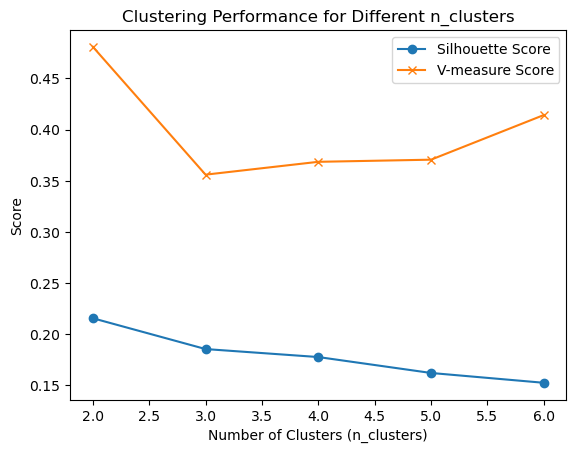

In [ ]:
# For exploration, we can see how different k numbers of centroids affects the clustering

# List of n_clusters values to explore
n_clusters_list = [2, 3, 4, 5, 6]

# Lists to store silhouette and V-measure scores
silhouette_scores = []
v_measure_scores = []

# Loop through different n_clusters values
for n_clusters in n_clusters_list:
    print(f"Clustering with n_clusters = {n_clusters}")

    # Create and Fit KMeans Model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(feature_vectors)

    # Get cluster labels
    labels = kmeans.labels_

    # Calculate and store metrics
    silhouette_avg = silhouette_score(feature_vectors, labels)
    v_measure = v_measure_score(true_labels, labels)

    silhouette_scores.append(silhouette_avg)
    v_measure_scores.append(v_measure)

import matplotlib.pyplot as plt

plt.plot(n_clusters_list, silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(n_clusters_list, v_measure_scores, marker='x', label='V-measure Score')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Score')
plt.title('Clustering Performance for Different n_clusters')
plt.legend()
plt.show()

In [ ]:
# We can see that the metrics tells a mixed story here.

# While silhouette score decreases with number of clusters, indicating poorer clustering,
# the V-measure is actually better at n_clusters = 2 and = 6.

# Crucially, there is no number of clusters across both metrics that give a good result.
# Hence, the final hypothesis is that the feature detection method or clustering model used is not suitable.
# In the cell below, we attempt to use just contour detection, on a smaller subset of images, to obtain a better result.

In [35]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.decomposition import PCA
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming your dataset_path and categories are defined earlier in the notebook
# dataset_path = ... (path to your rice image dataset)
# categories = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Function to get rice type from filename (defined earlier in the notebook)
def get_rice_type(filename):
    return filename.split(' ')[0]

# Create a mapping of rice types to numerical labels
rice_types = set(get_rice_type(filename) for filename in features_dict.keys())  # Assuming features_dict is available
rice_type_to_label = {rice_type: i for i, rice_type in enumerate(rice_types)}


# Collect all image file paths in a list
image_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
            image_files.append(os.path.join(root, file))

# Create category_dict
category_dict = {cat: [] for cat in categories}
for filepath in image_files:
    basename = os.path.basename(filepath).lower()
    for cat in categories:
        if cat.lower() in basename:
            category_dict[cat].append(filepath)
            break

# Select 5000 images per category
subset_category_dict = {}
for category, filepaths in category_dict.items():
    subset_category_dict[category] = filepaths[:5000]

def extract_features_with_contours_only_subset(subset_category_dict, num_components=50):
    """
    Extracts features from a subset of images using only contour-based shape descriptors,
    and performs dimensionality reduction using PCA.

    Args:
        subset_category_dict (dict): Dictionary where keys are categories and
                               values are lists of image file paths (subset).
        num_components (int): Number of principal components to keep (default: 50).

    Returns:
        tuple: A tuple containing the features dictionary, the fitted PCA object,
               and the true labels for the subset.
    """

    features_dict = {}
    true_labels_subset = []

    total_images = sum(len(filepaths) for filepaths in subset_category_dict.values())


    with tqdm(total=25000, desc="Extracting Features") as pbar:
        counter = 0
        for category, filepaths in subset_category_dict.items():
            for image_path in filepaths:
                try:
                    # 1. Load and preprocess the image
                    image = load_img(image_path, target_size=(224, 224))
                    image_array = img_to_array(image)
    
                    # 2. Contour Detection and Shape Descriptors
                    gray_image = cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_BGR2GRAY)
                    _, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
                    # Assuming the largest contour is the rice grain
                    largest_contour = max(contours, key=cv2.contourArea)
    
                    # Calculate shape descriptors
                    area = cv2.contourArea(largest_contour)
                    perimeter = cv2.arcLength(largest_contour, True)
                    eccentricity = 0
                    aspect_ratio = 0
                    solidity = 0
    
                    if len(largest_contour) >= 5:
                        (x, y), (MA, ma), angle = cv2.fitEllipse(largest_contour)
                                            # Check if MA is greater than ma and not zero
                        if MA > ma and MA != 0:  
                            eccentricity = np.sqrt(1 - (ma**2 / MA**2))
                        else:
                            eccentricity = 0  # or some other default value if MA <= ma or MA == 0
    
                        x, y, w, h = cv2.boundingRect(largest_contour)
                        aspect_ratio = float(w) / h
    
                    if area > 0:
                        hull = cv2.convexHull(largest_contour)
                        hull_area = cv2.contourArea(hull)
                        solidity = float(area) / hull_area
    
                    shape_descriptors = [area, perimeter, eccentricity, aspect_ratio, solidity]
    
                    # 3. Store features and true label in the dictionary
                    filename = os.path.basename(image_path)
                    features_dict[filename] = shape_descriptors  # Store shape descriptors directly
                    true_labels_subset.append(rice_type_to_label[get_rice_type(filename)])
    
                    counter += 1
                    if counter % 50 == 0:
                        pbar.update(50)
    
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # 4. Perform dimensionality reduction using PCA (if needed)
    all_features = np.array(list(features_dict.values()))
    
    # Check if there are features to reduce
    if all_features.shape[1] > num_components:
      pca = PCA(n_components=num_components)
      reduced_features = pca.fit_transform(all_features)

      # 5. Update features_dict with reduced features (if PCA was applied)
      for i, filename in enumerate(features_dict.keys()):
          features_dict[filename] = reduced_features[i]
    else:
        pca = None  # No PCA applied if num_features <= num_components

    return features_dict, pca, true_labels_subset

# Call the function with your subset_category_dict
features_dict, pca, true_labels_subset = extract_features_with_contours_only_subset(subset_category_dict)


# Define features_subset
features_subset = np.array(list(features_dict.values()))

# Perform KMeans clustering (adjust n_clusters as needed)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(features_subset)
labels_subset = kmeans.labels_

# Calculate and print metrics
silhouette_avg = silhouette_score(features_subset, labels_subset)
homogeneity = homogeneity_score(true_labels_subset, labels_subset)
completeness = completeness_score(true_labels_subset, labels_subset)
v_measure = v_measure_score(true_labels_subset, labels_subset)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Homogeneity: {homogeneity}")
print(f"Completeness: {completeness}")
print(f"V-measure: {v_measure}")

Extracting Features: 100%|███████████████| 25000/25000 [00:27<00:00, 906.06it/s]


Silhouette Score: 0.5356735267094366
Homogeneity: 0.4422491632232277
Completeness: 0.47636892147632737
V-measure: 0.45867539604853436


In [ ]:
# On a much smaller training set (1/3 in size), the results obtained by just using contour detection already far
# surpasses that of feature extraction using VGG16. Specifically, silhouette score was almost 0.4 better, while 
# the other three matrics were at most 0.08 worse. 

# A deeper dive into VGG16 yielded the following insights:
"""
1. VGG16 was trained on a much larger, much more diverse, and much more complex set of images (ImageNet). 
Given that our problem consists of greyscale images with simple contours, the low accuracy may be caused by overfitting. 

2. Sunyoto et al. (2022) found that datasets with more than 5000 images led to poorer performance of VGG16. Given that our
dataset has 75000 images, this may also compromise the performance. 

Reference:
Andi Sunyoto, Yoga Pristyanto, Arief Setyanto, Fawaz Alarfaj, Naif Almusallam and Mohammed Alreshoodi,
“The Performance Evaluation of Transfer Learning VGG16 Algorithm on Various Chest X-ray Imaging Datasets for COVID-19 Classification”
International Journal of Advanced Computer Science and Applications(IJACSA), 13(9), 2022. http://dx.doi.org/10.14569/IJACSA.2022.0130923


# **Relation to Real World**